In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils.greeks as gr
import Utils.option_pricing_utils as opu

In [51]:
option_exposure = -100000  # Number of options held in portfolio that we want to hedge
S0 = 49
r = 0.05
sigma = 0.2
sigma2 = 0.2 # Realized vol of the path (greater than vol used in BS price - we underestimate)
q = 0
T = 20/52 #20/52
K = 50
type = 'c'

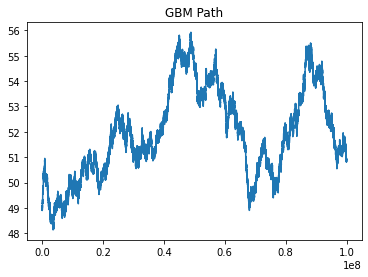

In [52]:
# Geometric Brownian Motion
# dSt = rSt dt + sigma*St dWt
#np.random.seed(seed=1)
M = 100000000
W = np.random.normal(loc=0.0, scale=1.0, size=M)
T_array = np.linspace(T, 0, M)
dt = T_array[0] - T_array[1]

S = np.zeros(M)
S[0] = S0
for i in range(M-1):
    S[i+1] = S[i] + r*S[i]*dt + sigma2*S[i]*W[i]*np.sqrt(dt)

plt.plot(S)
plt.title('GBM Path')
plt.show()

In [53]:
delta_array = gr.get_delta(S, K, T_array, sigma, r, q, type)
gamma_array = gr.get_gamma(S, K, T_array, sigma, r, q, type)
theta_array = gr.get_theta(S, K, T_array, sigma, r, q, type)
option_value_array = opu.get_bs_price_analytical(S, K, T_array, sigma, r, q, type)*option_exposure

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:19: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(d1)*np.exp(-q*T)/(S*sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:26: RuntimeWarning: invalid value encountered in true_divide
  theta_call = -r*K*np.exp(-r*T)*norm.cdf(d2) - S*norm.pdf(d1)*sigma*np.exp(-q*T)/(2*np.sqrt(T)) + q*S*norm.cdf(d1)*np.exp(-q*T)


The time of execution of is: 23.35174250602722
Option price is [2.40052732 2.40034296 2.40016805 ... 0.91890866 0.91962742 0.91898848]


In [54]:
summary_df = pd.DataFrame(list(zip(S, option_value_array, delta_array)), columns=['Stock_Price', 'Option_Value', 'Delta'])
summary_df

,Stock_Price,Option_Value,Delta
0,49.000000,-240052.732327,0.521605
1,48.999647,-240034.295570,0.521581
2,48.999311,-240016.805298,0.521560
3,48.998781,-239989.163314,0.521525
4,48.999019,-240001.539448,0.521540
...,...,...,...
99999995,50.917948,-91794.845542,1.000000
99999996,50.919191,-91919.059819,1.000000
99999997,50.918909,-91890.866009,1.000000
99999998,50.919627,-91962.742379,1.000000


In [55]:
summary_df['Shares_Held'] = -option_exposure*delta_array
summary_df['Shares_Purchased'] = -summary_df['Shares_Held'].sub(summary_df['Shares_Held'].shift(-1).fillna(0)).shift().fillna(-summary_df['Shares_Held'])
summary_df['Cost_of_Shares_Purchased'] = summary_df['Shares_Purchased'].mul(summary_df['Stock_Price'])
summary_df['Cumulative_Cost'] = summary_df['Cost_of_Shares_Purchased'].cumsum()
summary_df['Share_PnL'] = summary_df['Shares_Held'].shift()*(summary_df['Stock_Price'] - summary_df['Stock_Price'].shift())
summary_df['Interest_Cost'] = (summary_df['Shares_Held']*summary_df['Stock_Price']).shift()*r*dt + summary_df['Option_Value'].shift()*r*dt
summary_df['Option_PnL'] = summary_df['Option_Value'] - summary_df['Option_Value'].shift()
summary_df['Portfolio_PnL'] = summary_df['Share_PnL'] - summary_df['Interest_Cost'] 
summary_df['Hedged_Portfolio_PnL'] = summary_df['Portfolio_PnL'] + summary_df['Option_PnL'] 
summary_df

,Stock_Price,Option_Value,Delta,Shares_Held,Shares_Purchased,Cost_of_Shares_Purchased,Cumulative_Cost,Share_PnL,Interest_Cost,Option_PnL,Portfolio_PnL,Hedged_Portfolio_PnL
0,49.000000,-240052.732327,0.521605,52160.466107,52160.466107,2.555863e+06,2.555863e+06,NaN,NaN,NaN,NaN,NaN
1,48.999647,-240034.295570,0.521581,52158.149441,-2.316666,-1.135158e+02,2.555749e+06,-18.435511,0.000445,18.436757,-18.435956,8.011355e-04
2,48.999311,-240016.805298,0.521560,52155.951595,-2.197846,-1.076929e+02,2.555642e+06,-17.488984,0.000445,17.490272,-17.489430,8.420550e-04
3,48.998781,-239989.163314,0.521525,52152.477765,-3.473830,-1.702135e+02,2.555471e+06,-27.641249,0.000445,27.641984,-27.641694,2.900025e-04
4,48.999019,-240001.539448,0.521540,52154.033328,1.555564,7.622109e+01,2.555548e+06,12.377605,0.000445,-12.376134,12.377160,1.025945e-03
...,...,...,...,...,...,...,...,...,...,...,...,...
99999995,50.917948,-91794.845542,1.000000,100000.000000,-0.000000,-0.000000e+00,5.172088e+06,-0.979120,0.000962,0.980082,-0.980082,6.502638e-10
99999996,50.919191,-91919.059819,1.000000,100000.000000,-0.000000,-0.000000e+00,5.172088e+06,124.215239,0.000962,-124.214278,124.214278,-7.706547e-11
99999997,50.918909,-91890.866009,1.000000,100000.000000,-0.000000,-0.000000e+00,5.172088e+06,-28.192849,0.000962,28.193811,-28.193811,-6.678746e-11
99999998,50.919627,-91962.742379,1.000000,100000.000000,-0.000000,-0.000000e+00,5.172088e+06,71.877332,0.000962,-71.876370,71.876370,-6.515677e-11


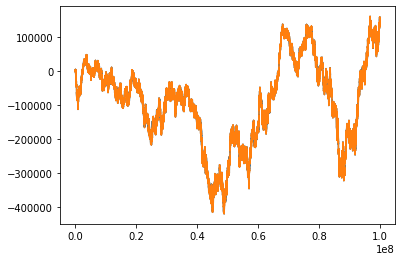

In [56]:
plt.plot(summary_df['Option_PnL'].cumsum())
plt.plot(-summary_df['Portfolio_PnL'].cumsum())

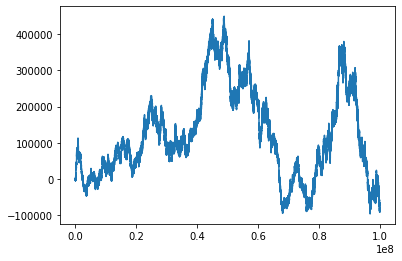

In [57]:
plt.plot(summary_df['Share_PnL'].cumsum())


In [58]:
hedging_pnl = summary_df['Option_PnL'].cumsum().iloc[-1]+summary_df['Portfolio_PnL'].cumsum().iloc[-1]
print(f'Hedging Error: ${hedging_pnl}')


Hedging Error: $33.75491359017906
